<a href="https://colab.research.google.com/github/zaegeon/Python/blob/main/ML/20220624_ML12_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Learning(앙상블 학습 방법)

* 앙상블(Ensemble) : 머신 러닝에서 사용되는 일련 모델(알고리즘)들.
    * 서로 다른 모델 여러 개를 학습시키는 방법.
    * 한 가지 모델을 서로 다른 훈련 셋에서 학습시키는 방법.
* 앙상블 학습 방법 : 앙상블을 사용한 머신 러닝 방법.
    * 투표(voting) 방식 : 여러 개의 모델을 학습시켜서 각각의 예측값을 투표(다수결, 최빈값) 또는 평균값으로 예측하는 방법.
    * __Bagging(Bootstrap Aggregating)__ : **중복을 허용**해서 샘플링한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측(최빈값, 평균)하는 학습 방법.
    * Pasting : 중복을 허용하지 않고 샘플링한 훈련 셋의 부분집합들을 알고리즘에 학습시켜서 예측하는 방법.
    * __Boosting__ : 약한 학습기를 순차적으로 연결해서 강한 학습기를 만드는 ensemble 학습 방법.
        * AdaBoost(Adactive Boosting) : 과소적합됐던 훈련 샘플들의 가중치를 높여서 다음 훈련에 순차적으로 사용하는 boosting 방법.
        * Gradient Boost : 잔여 오차(residual errors)들을 다음 훈련에서 학습시켜서 강한 학습기를 만드는 boosting 방법.
* __Random Forest__ : Bagging을 사용한 Decision Tree들의 ensemble 학습 방법.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC # SVM(Support Vector Machine) 알고리즘을 사용한 분류기
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier

# Dataset 준비

2개의 특성(x1, x2)과 2개의 클래스(0, 1)를 갖는 가상의 데이터 셋을 생성.

In [ ]:
# X : 특성 배열(Features) / y : 타겟 배열(Target)
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)

In [ ]:
X.shape, y.shape

((500, 2), (500,))

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([250, 250]))

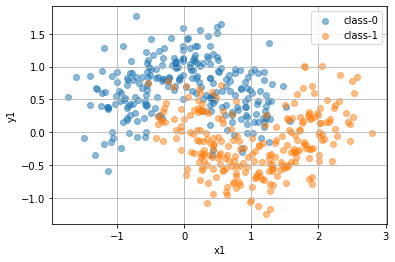

In [ ]:
# X, y를 시각화
plt.scatter(X[y==0, 0], X[y==0, 1], label='class-0', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], label='class-1', alpha=0.5)

plt.legend()
plt.grid()
plt.xlabel('x1')
plt.ylabel('y1')
plt.show()

In [ ]:
# train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((400, 2), (100, 2), (400,), (100,))

# 머신 러닝 모델의 성능 비교

* 5개의 머신 러닝 모델 생성
    * KNN, Decision Tree, Logistic Regression, SGD, SVM
        * SGDClassifier의 파라미터 중에서 `loss='log'`를 사용.
        * SVC의 파라미터 중에서 `probability=True`를 사용.
* 5개의 모델을 훈련 셋으로 학습
* 5개 모델의 점수(정확도)를 훈련 셋 / 테스트 셋에서 계산 후 비교

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1)
tree = DecisionTreeClassifier(random_state=42)
logistic = LogisticRegression(random_state=42, n_jobs=-1)
SGD = SGDClassifier(loss='log', random_state=42, n_jobs=-1)
#> loss='log' : 각 클래스가 될 확률을 계산해서 예측하기 위함.
SVM = SVC(probability=True, random_state=42)
#> probability=True : 각 클래스가 될 확률을 계산해서 예측하기 위함.

In [ ]:
classifiers = [knn, tree, logistic, SGD, SVM] # 반복문에서 사용하기 위한 리스트 생성
for c in classifiers:
    c.fit(X_tr, y_tr)              # 분류기를 훈련 데이터에 학습시킴
    tr_score = c.score(X_tr, y_tr) # 훈련 셋 정확도
    te_score = c.score(X_te, y_te) # 테스트 셋 정확도
    print(f'{c.__class__.__name__} - train acc : {tr_score}, test acc : {te_score}')

KNeighborsClassifier - train acc : 0.93, test acc : 0.93
DecisionTreeClassifier - train acc : 1.0, test acc : 0.84
LogisticRegression - train acc : 0.8475, test acc : 0.81
SGDClassifier - train acc : 0.8425, test acc : 0.81
SVC - train acc : 0.9275, test acc : 0.93


# Voting Ensemble

In [ ]:
vote_clf = VotingClassifier(estimators=[('knn', knn),
                                        ('tree', tree),
                                        ('logistic', logistic),
                                        ('sgd', SGD),
                                        ('svm', SVM)],
                            voting='soft',
                            n_jobs=-1)
#> estimators : VotingEnsemble을 만들기 위한 ML 모델 ('모델 이름', 모델 객체) tuple들의 리스트.
#> voting : 투표 방식
#>>> voting='hard' : 기본값. 앙상블의 각 모델들이 동일하게 1표씩 행사. 예측 확률이 필요 없음!
#>>> voting='soft' : 앙상블의 각 모델의 예측값에 예측 확률을 가중치로 곱한 값을 사용해서 예측.
#>>> 일반적으로는 soft voting 방식의 성능이 더 좋다고 알려져 있음.

In [ ]:
# voting ensemble을 훈련
vote_clf.fit(X_tr, y_tr)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_jobs=-1)),
                             ('tree', DecisionTreeClassifier(random_state=42)),
                             ('logistic',
                              LogisticRegression(n_jobs=-1, random_state=42)),
                             ('sgd',
                              SGDClassifier(loss='log', n_jobs=-1,
                                            random_state=42)),
                             ('svm', SVC(probability=True, random_state=42))],
                 n_jobs=-1, voting='soft')

In [ ]:
# 훈련/테스트 셋 정확도
print('train acc :', vote_clf.score(X_tr, y_tr))
print('test acc :', vote_clf.score(X_te, y_te))

train acc : 0.94
test acc : 0.92


# Bagging Ensemble

In [ ]:
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    max_samples=100,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
    )

BaggingClassifier의 파라미터들:

* base_estimator : 기본 추정기(예측기). 머신 러닝 모델 객체.
* n_estimators : 추정기(예측기)의 개수. 기본값 10.
* max_samples : 훈련 셋의 부분 집합이 가질 수 있는 최대 샘플 개수(정수) 또는 비율(0 ~ 1.0). 기본값은 1.0.
* bootstrap : True(중복 허용 샘플링, bagging). False(중복 불허 샘플링, pasting). 기본값은 True.
* oob_score : True(OOB 샘플로 평가 점수 계산). False(OOB 샘플로 평가 점수를 계산하지 않음). 기본값은 False.
    * OOB(Out-Of-Bagging) 샘플 : 중복 허용 샘플링을 하는 동안 한 번도 샘플링되지 못하고 남아 있는 훈련 셋의 샘플.
    * OOB sample은 validation set 역할을 할 수 있음.

In [ ]:
bagging_clf.fit(X_tr, y_tr) # 모델 훈련

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=50, n_jobs=-1, oob_score=True,
                  random_state=42)

In [ ]:
bagging_clf.oob_score_
# OOB(Out-Of-Bagging) 샘플들로 계산한 점수(정확도)
# OOB score는 일반적으로 테스트 셋 점수보다 약간 좋거나 비슷.

0.91

In [ ]:
print('train acc :', bagging_clf.score(X_tr, y_tr))
print('test acc :', bagging_clf.score(X_te, y_te))

train acc : 0.9425
test acc : 0.9


In [ ]:
# n_estimator=100, max_samples=1.0 설정해서 교차 검증(cross_validate)
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    max_samples=1.0,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

In [ ]:
cv = cross_validate(bagging_clf, X_tr, y_tr, n_jobs=-1, return_train_score=True)

In [ ]:
print('train acc :', np.mean(cv['train_score']))
print('test acc :', np.mean(cv['test_score']))

train acc : 1.0
test acc : 0.9075


# Random Forest

In [ ]:
forest_clf = RandomForestClassifier(n_estimators=50, max_samples=100, oob_score=True,
                                    random_state=42, n_jobs=-1)

In [ ]:
forest_clf.fit(X_tr, y_tr)

RandomForestClassifier(max_samples=100, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=42)

In [ ]:
forest_clf.oob_score_

0.9125

In [ ]:
print('train acc :', forest_clf.score(X_tr, y_tr))
print('test acc :', forest_clf.score(X_te, y_te))

train acc : 0.9475
test acc : 0.91


Random Forest : Decision Tree를 사용하는 bagging ensemble 학습 방법.

* DecisionTree의 파라미터와 Bagging의 파라미터를 가짐.
* GridSearchCV, RandomizedSearchCV을 사용해서 tree와 bagging의 하이퍼파라미터들을 튜닝할 수 있음.

# RandomForest를 사용한 wine datasets 분류

In [ ]:
# wine datasets
wine_csv = 'https://bit.ly/wine_csv_data'
wine = pd.read_csv(wine_csv)

In [ ]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [ ]:
X1 = wine.iloc[:, :3].values.copy()
y1 = wine['class'].values.astype('int').copy()

In [ ]:
X1_tr, X1_te, y1_tr, y1_te = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)

In [ ]:
X1_tr.shape, X1_te.shape, y1_tr.shape, y1_te.shape

((5197, 3), (1300, 3), (5197,), (1300,))

In [ ]:
params1 = {'n_estimators' : np.arange(1, 11),
          'max_samples' : np.arange(0.1, 1.01, 0.1)}

In [ ]:
grid_cv = GridSearchCV(estimator=RandomForestClassifier(oob_score=True, random_state=42),
                       param_grid=params1, n_jobs=-1)

In [ ]:
grid_cv.fit(X1_tr, y1_tr)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


GridSearchCV(estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [ ]:
grid_cv.best_params_

{'max_samples': 1.0, 'n_estimators': 9}

In [ ]:
grid_cv.best_score_

0.8874339231509587

In [ ]:
best_rf = grid_cv.best_estimator_
best_rf

RandomForestClassifier(max_samples=1.0, n_estimators=9, oob_score=True,
                       random_state=42)

In [ ]:
print('Best Train Score :', best_rf.score(X1_tr, y1_tr))
print('Best Test Score :', best_rf.score(X1_te, y1_te))

Best Train Score : 0.9880700404079277
Best Test Score : 0.8830769230769231


In [ ]:
params_r1 = {'n_estimators' : scipy.stats.randint(1, 11),
             'max_samples' : scipy.stats.uniform(0, 0.1)}

In [ ]:
rand_cv = RandomizedSearchCV(estimator=RandomForestClassifier(oob_score=True, random_state=42),
                             param_distributions=params_r1, # 파라미터들의 확률분포
                             n_iter=100, # 파라미터 조합의 개수
                             n_jobs=-1)

In [ ]:
rand_cv.fit(X1_tr, y1_tr)

RandomizedSearchCV(estimator=RandomForestClassifier(oob_score=True,
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb3d8026c10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb3d8026d10>})

In [ ]:
rand_cv.best_params_

{'max_samples': 0.08626715851607705, 'n_estimators': 9}

In [ ]:
rand_cv.best_score_

0.8622234767157769

In [ ]:
best_rf = rand_cv.best_estimator_
best_rf

RandomForestClassifier(max_samples=0.08626715851607705, n_estimators=9,
                       oob_score=True, random_state=42)

In [ ]:
print("Best Train Score :", best_rf.score(X1_tr, y1_tr))
print("Best Test Score :", best_rf.score(X1_te, y1_te))

Best Train Score : 0.885510871656725
Best Test Score : 0.8553846153846154


# RandomForest를 사용한 breast-cancer 분류

In [ ]:
cancer = datasets.load_breast_cancer()

In [ ]:
cancer_df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
X2 = cancer.data.copy()  # cancer['data']
y2 = cancer.target.copy()  # cancer['target']

In [ ]:
X2_tr, X2_te, y2_tr, y2_te = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

In [ ]:
X2_tr.shape, X2_te.shape, y2_tr.shape, y2_te.shape

((455, 30), (114, 30), (455,), (114,))

In [ ]:
grid_cv = GridSearchCV(estimator=RandomForestClassifier(oob_score=True, random_state=42),
                       param_grid=params1, n_jobs=-1)

In [ ]:
grid_cv.fit(X2_tr, y2_tr)

GridSearchCV(estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [ ]:
grid_cv.best_params_

{'max_samples': 0.2, 'n_estimators': 9}

In [ ]:
grid_cv.best_score_

0.956043956043956

In [ ]:
best_rf = grid_cv.best_estimator_
best_rf

RandomForestClassifier(max_samples=0.2, n_estimators=9, oob_score=True,
                       random_state=42)

In [ ]:
print("Best Train Score :", best_rf.score(X2_tr, y2_tr))
print("Best Test Score :", best_rf.score(X2_te, y2_te))

Best Train Score : 0.9538461538461539
Best Test Score : 0.9298245614035088


In [ ]:
rand_cv = RandomizedSearchCV(estimator=RandomForestClassifier(oob_score=True, random_state=42),
                             param_distributions=params_r1, # 파라미터들의 확률분포
                             n_iter=100, # 파라미터 조합의 개수
                             n_jobs=-1)

In [ ]:
rand_cv.fit(X2_tr, y2_tr)

RandomizedSearchCV(estimator=RandomForestClassifier(oob_score=True,
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb3d8026c10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb3d8026d10>})

In [ ]:
rand_cv.best_params_

{'max_samples': 0.06869184768070863, 'n_estimators': 10}

In [ ]:
rand_cv.best_score_

0.9428571428571428

In [ ]:
best_rf = rand_cv.best_estimator_
best_rf

RandomForestClassifier(max_samples=0.06869184768070863, n_estimators=10,
                       oob_score=True, random_state=42)

In [ ]:
print("Best Train Score :", best_rf.score(X2_tr, y2_tr))
print("Best Test Score :", best_rf.score(X2_te, y2_te))

Best Train Score : 0.9406593406593406
Best Test Score : 0.9385964912280702
